<a href="https://colab.research.google.com/github/jlsneto/3d-pose-baseline/blob/master/motion/HT_KEYPOINTS_TOOLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gcsfs firebase-admin
!pip install cereja
import math
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from google.colab import files
from datetime import datetime
import firebase_admin 
from firebase_admin import credentials, firestore, storage
from firebase_admin.firestore import SERVER_TIMESTAMP
import cereja as cj
from firebase_admin import auth as fb_auth
from unicodedata import normalize
import re
import hashlib
import os
from firebase_admin import db as fb_db

from google.colab import auth
auth.authenticate_user()

In [2]:

print("Faça o upload do arquivo json do service accounts do community. Se não tiver um, peça ao Thadeu.")
uploaded = files.upload()
creds_file = list(uploaded.keys())[0]

os.environ['GOOGLE_CLOUD_PROJECT'] = "ht-community"
# Inicializa o sdk do firebase
print("Inicializando firestore..")
creds = credentials.Certificate(creds_file)
firebase_admin.initialize_app(creds, { 'storageBucket': 'ht-community.appspot.com' })
db_realtime = fb_db.reference(url="https://ht-community.firebaseio.com/")



db = firestore.client()

Faça o upload do arquivo json do service accounts do community. Se não tiver um, peça ao Thadeu.


Saving key.json to key.json
Inicializando firestore..


In [61]:
def _firestore_query(collection: str, workspace=None, where_config = (), limit=None, order_by=None, start_after=None):
    assert where_config is not None or isinstance(where_config, list), "where_config deve ser uma lista de verificações: ex. ['meuCampo', '==', True]"
    if workspace is not None:
        assert workspace and collection, f"workspace ({workspace}) ou collection ({collection}) inválido."
        print(f"Buscando {collection} em {workspace}")
        query = db.collection('workspaces').document(workspace).collection(collection)
    else:
        print(f"Buscando {collection}")
        query = db.collection_group(collection)
    
    assert not (start_after and where_config), "Não é possível usar start_after com where"
    # Where
    if where_config:
        for _field, _op, _value in where_config:
            query = query.where(_field, _op, _value)

    # Order by
    if order_by is not None:
        if isinstance(order_by, (tuple, list)):
            assert len(order_by) == 2, f"{order_by} invalid."
            field, order = order_by
            if order == 'desc':
                query = query.order_by(field, direction=firestore.Query.DESCENDING)
            else:
                query = query.order_by(field)
        else:
            query = query.order_by(order_by)
        
    if start_after:
        query = query.start_after(start_after)
    # Limit
    if limit is not None:
        assert isinstance(limit, int)
        query = query.limit(limit)
    
    return [{ "data": snap.to_dict(), "id": snap.id, "ref": snap.reference } for snap in query.stream()]
    
def get_document(workspace, collection, id):
    return db.collection('workspaces').document(WORKSPACE).collection(collection).document(id)

def list_collection_from_workspace(workspace: str, collection: str, where_config = (), limit=None, order_by=None, start_after=None):
    return _firestore_query(collection, workspace, where_config, limit, order_by,start_after)

def list_collections(collection: str, where_config = (), limit=None, order_by=None):
    assert collection, f"collection ({collection}) inválido."
    return _firestore_query(collection, workspace=None, where_config=where_config, limit=limit, order_by=order_by)

def get_user_ref(id):
    return db.collection('users').document(id)

def get_struct(workspace, collection) -> set:
    return set(next(db.collection('workspaces').document(workspace).collection(collection).order_by('createdAt', direction=firestore.Query.DESCENDING).limit(1).stream()).to_dict())
def get_struct_problems(data, workspace, collection):
    default_struct = get_struct(workspace=workspace, collection=collection)
    struct_problems = {}
    for i in data:
        if 'createdAt' in i:
            keys = i.keys()
        else:
            keys = i['data'].keys()
        problems = default_struct.difference(set(keys))
        if problems:
            struct_problems[i['ref']] = problems
    cj.console.log(f'Indentificado problemas estruturais em {{red}}{len(struct_problems)}{{endred}} registros da coleção de {collection}.')
    return struct_problems

def firestore_data_from_collection(collection, workspace, get_problems = False):
    date = datetime(2000, 1, 1, 0,0)
    limit = 30000
    query_result = []
    while True:
        result = list_collection_from_workspace(
        workspace=workspace,
        collection=collection,
        limit=limit,
        order_by='createdAt',
        start_after={'createdAt': date}
        )
        date = result[-1]['data']['createdAt']
        print(date)
        query_result.extend(result)
        print("Encontrou", len(result), collection, f"Total de {collection}", len(query_result))
        if len(result) != limit:
            break

    struct_problems = get_struct_problems(data=query_result, workspace=workspace, collection=collection)

    if struct_problems:
        cj.console.log(f"Para retornar os problemas com os resultados envie {{blue}}get_problems=True{{endblue}} ou use a função {{yellow}}get_struct_problems{{endyellow}}")
        if get_problems:
            cj.console.log("O retorno está no seguinte formato (query_result, problems).", color='red')
            return query_result, problems
    return query_result

def run_batches_operation(operations, operation_type='update'):
    input(cj.console.template_format(f"Digite {{red}}sim{{endred}} para confirmar a alteração em {len(operations)} registros"))
    number_of_chunks = math.ceil(len(operations) / 500)
    chunks = np.array_split(operations, number_of_chunks)
    for chunk in tqdm(chunks):
        batch = db.batch()

        for ref, update_obj in chunk:
            if operation_type == 'update':
                batch.update(ref, update_obj)
            # Por questões de segurança, outras operações estão comentadas
            # if operation_type == 'set':
            #     batch.set(ref, update_obj)
            # if operation_type == 'delete':
            #     batch.delete(ref)

        batch.commit()

def inverted(data):
    new_dict = {}
    for key in data:
        if isinstance(data[key], (tuple, list, set, dict)):
            new_dict.update({k: key for k in data[key]})
            continue
        new_dict[data] = key
    return new_dict

def show_local_mp4_video(file_name, width=640, height=480):
    import io
    import base64
    from IPython.display import HTML
    video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
    return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                    </video>'''.format(width, height, video_encoded.decode('ascii')))

In [12]:
WORKSPACE = "HT-Annoy" #@param ["HT-ASL", "HT-BZS", "HT-Annoy", "development", "HT-BZS-JOAB"] {allow-input: true}

# Pega todos os vídeos e segmentos

In [ ]:
%%time
SEGMENTS = firestore_data_from_collection('segments', workspace=WORKSPACE)
SEGMENTS.sort(key=lambda x: x['data']['createdAt'], reverse=True)
VIDEOS = firestore_data_from_collection('videos', workspace=WORKSPACE)
VIDEOS.sort(key=lambda x: x['data']['createdAt'], reverse=True)
videos_data = {item['id']: item['data']['sentence'] for item in VIDEOS}
segment_data = {item['id']: (item['data']['video'].id, item['data']['startFrame'], item['data']['endFrame']) for item in SEGMENTS}

# Keypoints Tool

In [74]:
from typing import Tuple, Union, List
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import tempfile
import os

try:
    # noinspection PyUnresolvedReferences
    get_ipython()
    ON_JUPYTER = True
except NameError:
    ON_JUPYTER = False

class ConnectValues(dict):
    def __init__(self, name: str = None):
        super().__init__()
        self._name = name

    @property
    def name(self):
        return self._name

    @property
    def all(self):
        for connection in self._get_connections():
            yield connection, set(self._get_connections(connection))

    def _get_connections(self, value=None):
        if value is not None:
            connections_ = filter(lambda x: value in x, self)
        else:
            connections_ = self
        for k in connections_:
            for v in k:
                yield v

    def connect(self, a, b, confidence=0.0):
        self.update({tuple(sorted((a, b))): confidence})

    def get(self, a):
        return set(self._get_connections(a))

    def confidence(self, a, b):
        return self[(tuple(sorted((a, b))))]

    def clusters(self):
        segment_matches = {}
        # I create a map containing all matches (value) of a given segment (including itself)
        for k, v in self.all:
            segment_matches[k] = v
        # cluster identifier
        cluster = 0
        clusters = {}
        while segment_matches:
            temp_matches = iter(list(segment_matches.items()))
            # remove and store all matches from this segment (set A)
            segment_id, _ = next(temp_matches)
            clusters[cluster] = segment_matches.pop(segment_id)
            while clusters[cluster].intersection(segment_matches):
                # If there is an intersection between set A and set B
                # it is understood that A is equal to B
                for k in clusters[cluster].intersection(segment_matches):
                    # for each item that is in A and B at the same time I add A and remove it from B
                    clusters[cluster].update(segment_matches.pop(k))
            cluster += 1
        return clusters


class Keypoint:
    def __init__(self, key: int, x: float, y: float, z: float = None, confidence: float = -1.0, name: str = None):
        self._key = key
        self._name = name
        self._x = x
        self._y = y
        self._z = z
        self._confidence = confidence

    def __repr__(self):
        return f"{self._name}"

    @property
    def confidence(self):
        return self._confidence

    @property
    def name(self):
        return self._name

    @property
    def key(self):
        return self._key

    @property
    def x(self):
        return self._x

    @property
    def y(self):
        return self._y

    @property
    def z(self):
        return self._z

    @property
    def coord(self):
        return self._x, self._y, self._z

    def update(self, x: float, y: float, z: float = None):
        x = x or 0.0
        y = y or 0.0
        z = z or 0.0
        self._x, self._y, self._z = x, y, z


class PartKeypoints:
    points_config = None
    points_connection = ()
    name = None
    _need_implement = {'points_config':"""
Defina a configuração dos keypoints na classe {class_name}:
exemplo:

class {class_name}:
    points_config = {{
                        0:  'nose',
                        1:  'leftEye',
                        2:  'rightEye',
                        3:  'leftEar',
                        4:  'rightEar',
                        5:  'leftShoulder',
                        6:  'rightShoulder',
                        7:  'leftElbow',
                        8:  'rightElbow',
                        9:  'leftWrist',
                        10: 'rightWrist',
                        11: 'leftHip',
                        12: 'rightHip',
                        13: 'leftKnee',
                        14: 'rightKnee',
                        15: 'leftAnkle',
                        16: 'rightAnkle'
                    }}
""",
    'name': """
Defina a configuração dos keypoints na classe {class_name}:
exemplo:

class {class_name}:
    name = "NameOfThis"
    """}

    def __init__(self, id_: str, initial_coord=(0.0, 0.0, 0.0)):
        self._id = id_
        if self.points_config:
            self._connections = ConnectValues(id_)
            self._n_points = len(self.points_config)
            self._name_to_key = dict(zip(self.points_config.values(), self.points_config.keys()))
            self._points = {key: Keypoint(key, *initial_coord, name=k_name) for key, k_name in self.points_config.items()}

            for point_a, point_b in self.points_connection:
                self.add_connection(point_a, point_b)
        else:
            self._connections = ConnectValues(id_)
            self._n_points = 0
            self._name_to_key = {}
            self._points = {}
        
        for i, key in self._name_to_key.items():
            setattr(self, i, self._points[key])

    def __init_subclass__(cls, **kwargs):
        for attr in cls._need_implement:
            if not getattr(cls, attr):
                raise NotImplementedError(cls._need_implement.get(attr).format(class_name=cls.__name__))
    
    def __repr__(self):
        return f'{self.name}_{self.id}'
        
    @property
    def id(self):
        return self._id

    @property
    def n_points(self):
        return self._n_points

    @property
    def points(self) -> Tuple[Keypoint]:
        return tuple(self._points.values())

    @property
    def x(self):
        return tuple(map(lambda point: point.x, self.points))
    
    @property
    def y(self):
        return tuple(map(lambda point: point.y, self.points))
    
    @property
    def z(self):
        return tuple(map(lambda point: point.z, self.points))

    def get(self, key: int, default=None) -> Union['PartKeypoints', None]:
        return self._points.get(key, default)

    @property
    def connections(self):
        return tuple(map(lambda values: tuple(self.get(v) for v in values), self._connections))

    def add_connection(self, a, b):
        self._connections.connect(a, b)

    def __iter__(self):
        for i in self._points.values():
            yield i

    def __getitem__(self, value):
        if isinstance(value, tuple):
            raise ValueError("send id")
        if isinstance(value, str):
            value = self._name_to_key[value]
        return self._points[value]

    def plot(self, show=True):
        for (point_a, point_b), color in zip(self.connections, self.colors_config):
            try:
                # if not all(list(point_a.coord)[:1] + list(point_b.coord)[:1]):
                #     continue
                if point_a.x == 0 or point_b.x == 0:
                    continue
            except:
                print("ERROR")
                continue
            plt.plot([point_a.x * -1, point_b.x*-1], [point_a.y*-1,  point_b.y*-1], color=[i/255 for i in color])
        if show:
            plt.show()

    @classmethod
    def load(cls, *args, **kwargs):
        raise NotImplementedError()
        
class BodyPoseNet(PartKeypoints):
    name = 'BodyPosinet'
    n_points = 17
    # points_connection = [[0, 1], [1, 2], [2, 3], [3, 4],
    #                     [1, 5], [5, 6], [6, 7],
    #                     [1, 14],
    #                     [14, 8], [8, 9], [9, 10], [14, 11], [11, 12], [12, 13]
    #                     ]
    points_config = {0:  'nose',
                    1:  'leftEye',
                    2:  'rightEye',
                    3:  'leftEar',
                    4:  'rightEar',
                    5:  'leftShoulder',
                    6:  'rightShoulder',
                    7:  'leftElbow',
                    8:  'rightElbow',
                    9:  'leftWrist',
                    10: 'rightWrist',
                    11: 'leftHip',
                    12: 'rightHip',
                    13: 'leftKnee',
                    14: 'rightKnee',
                    15: 'leftAnkle',
                    16: 'rightAnkle'
                    }
    points_connection = [[0,3], [0, 4], [5, 6], [5, 7], [6, 8], [7, 9], [8, 10]]
    colors_config = [(46, 130, 127),
                    (153, 78, 186),
                    (67, 46, 238),
                    (108, 48, 112),
                    (135, 94, 82),
                    (8, 54, 92),
                    (163, 35, 229),
                    (122, 46, 160),
                    (203, 22, 139),
                    (104, 150, 214),
                    (214, 1, 49),
                    (80, 3, 232),
                    (130, 174, 228),
                    (137, 65, 36),
                    (31, 192, 99),
                    (135, 86, 18),
                    (99, 152, 253)]

    @classmethod
    def load(cls, data: List[Tuple[Union[int, str], Tuple[float, float, float]]], name=None):
        name = name or cls.__name
        pass

class Hand(PartKeypoints):
    name = 'handpose'
    points_config = {0: 'hand',
                    1: 'thumb_root',
                    2: 'thumb_base',
                    3: 'thumb_mid',
                    4: 'thumb_tip',
                    5: 'index_root',
                    6: 'index_base',
                    7: 'index_mid',
                    8: 'index_tip',
                    9: 'middle_root',
                    10: 'middle_base',
                    11: 'middle_mid',
                    12: 'middle_tip',
                    13: 'ring_root',
                    14: 'ring_base',
                    15: 'ring_mid',
                    16: 'ring_tip',
                    17: 'pinky_root',
                    18: 'pinky_base',
                    19: 'pinky_mid',
                    20: 'pinky_tip'
                    }
    points_connection = [[0, 1], [0, 5], [0, 9], [0, 13], [0, 17], [1, 2], [2, 3], [3, 4], [5, 6], [
        6, 7], [7, 8], [9, 10], [10, 11], [11, 12], [13, 14], [14, 15], [15, 16], [17, 18], [18, 19], [19, 20]]
    colors_config = [(221, 162, 21),
                    (244, 157, 30),
                    (154, 109, 141),
                    (131, 220, 178),
                    (200, 209, 250),
                    (72, 128, 112),
                    (30, 128, 67),
                    (235, 243, 20),
                    (102, 176, 53),
                    (208, 135, 95),
                    (83, 64, 29),
                    (219, 151, 123),
                    (153, 192, 11),
                    (66, 15, 222),
                    (7, 191, 165),
                    (15, 148, 81),
                    (130, 238, 75),
                    (214, 210, 78),
                    (115, 149, 68),
                    (80, 125, 224),
                    (231, 132, 199)]
    @classmethod
    def load(cls, data: List[Tuple[Union[int, str], Tuple[float, float, float]]], name=None):
        name = name or cls.__name
        pass
    
class FrameKeypoint:
    def __init__(self, frame, body, left_hand, right_hand, face=None):
        self.frame = frame
        self.body = body
        self.left_hand = left_hand
        self.right_hand = right_hand
    
    def __repr__(self):
        return f"Frame({self.frame})"

    def plot(self, show=True):
        self.body.plot(show=False)
        self.left_hand.plot(show=False)
        self.right_hand.plot(show=False)
        if show:
            plt.show()
    
class VideoKeypoints:
    HT_STRUCT = {
        'leftHand': Hand,
        'rightHand': Hand,
        'posenet': BodyPoseNet
    }
    def __init__(self, n_frames, frames_data: List[Tuple[BodyPoseNet, Hand, Hand]] = None, video_id=''):
        self._video_id = video_id
        self._frames: List[FrameKeypoint] = []
        frames_data = frames_data or enumerate(map(lambda x: BodyPoseNet(x), Hand(x), Hand(x), range(n_frames)))
        for frame, (body, hand_left, hand_right) in frames_data:
            self._frames.append(FrameKeypoint(frame, body, hand_left, hand_right))
    @property
    def n_frames(self):
        return len(self._frames)

    @property
    def frames(self):
        return self._frames

    @property
    def id(self):
        return self._video_id
        
    def __repr__(self):
        return f"Video({self.n_frames})"

    def __iter__(self) -> FrameKeypoint:
        for i in self._frames:
            yield i

    def __getitem__(self, value):
        return self._frames[value]

    def plot(self, save_on=None, frame=None):
        if isinstance(frame, int):
            self[frame].plot()
            return

        if isinstance(frame, tuple):
            for i in self[slice(*frame)]:
                i.plot(show=False)
        else:
            for i in self:
                i.plot(show=False)

        if save_on:
            path_ = cj.Path(save_on)
            if not path_.exists and not path_.suffix:
                cj.mkdir(save_on)
            if path_.is_dir:
                # adiciona nome para arquivo
                name = self.id or random.randint(1, 100000)
                path_ = path_.join(f'{name}.jpeg')

            assert path_.suffix in ('.jpeg', '.jpg', '.png'), f'{path_.suffix}'
            plt.axis('off')
            plt.savefig(path_)
            plt.clf()
            return
        plt.show()

    def __len__(self):
        return len(self._frames)

    @staticmethod
    def _show_local_mp4_video(file_name, width=640, height=480):
        import io
        import base64
        from IPython.display import HTML
        video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
        return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                            <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                        </video>'''.format(width, height, video_encoded.decode('ascii')))

    def plot_mp4(self, save_on: str, frames=None, show_video=True):
        # Somente no colab
        assert ON_JUPYTER, "Esta função só está disponível em um Jupyter Notbook e é necessário ter o ffmpeg instalado."
        
        save_on = cj.Path(save_on).join(f"{self.id}.mp4")
        with tempfile.TemporaryDirectory() as tmp:
            for frame in self[slice(*frames)] if isinstance(frames, tuple) else self:
                frame.plot(show=False)
                n = frame.frame
                zeros = '0' * (4 - len(str(n)))
                n = zeros + str(n)
                file_name = cj.Path(tmp).join(f'{self.id}{n}.jpg')
                plt.axis('off')
                plt.savefig(file_name)
                plt.clf()
            !ffmpeg -f image2 -i "{tmp}"/"{self.id}"%04d.jpg -y "{save_on}" -hide_banner -loglevel panic

        if show_video:
            return self._show_local_mp4_video(save_on)

    @classmethod
    def load_from_ht_keypoints(cls, keypoints, video_id=''):
        result = {}

        for model_name, bones in keypoints.items():
            frames = {}
            result[model_name] = {}
            for bone, bone_data in bones.items():
                for frame, xyz in enumerate(zip(*bone_data.values())):
                    if frame not in result[model_name]:
                        result[model_name][frame] = cls.HT_STRUCT.get(model_name)(frame)
                    result[model_name][frame][bone].update(*xyz)


        max_frames = max(len(result['posenet']), len(result['rightHand']), len(result['leftHand']))
        min_frames = min(len(result['posenet']), len(result['rightHand']), len(result['leftHand']))
        step = int(max_frames/min_frames)

        return cls(min_frames, enumerate(zip(result['posenet'].values(),
                                  [i for n, i in enumerate(result['leftHand'].values()) if not n % step],
                                  [i for n, i in enumerate(result['rightHand'].values()) if not n % step]
                                  )), video_id=video_id)
        
    @classmethod
    def load_from_ht_storage(cls, workspace_id, videos = ()):
        bucket = storage.bucket()
        keypoints = {}
        blobs = map(bucket.get_blob, map(lambda video_id: f'{workspace_id}/ase/keypointsJson/{video_id}.json', videos)) \
            if videos else bucket.list_blobs(prefix=f'{workspace_id}/ase/keypointsJson')
        for blob in blobs:
            if blob is None:
                yield
            if blob.exists:
                yield cls.load_from_ht_keypoints(json.loads(blob.download_as_string()), cj.Path(blob.name).stem)
            

# Usando VideoKeypoints

In [68]:
videos = VideoKeypoints.load_from_ht_storage(WORKSPACE) # Generator (Pode retornar NONE se o arquivo de keypoints não existir)

In [33]:
# Armazenar em uma lista (Dependendo da quantidade pode demorar)
video = list(videos)

In [75]:
# você pode mandar vários ID's nesse caso só quero 1 por isso uso o next, sei que só tem 1 valor
video = next(VideoKeypoints.load_from_ht_storage(WORKSPACE, videos=['0TAugNhAco4z4IsO59zH']))
video

Video(151)

# Utilidades do VideoKeypoints

In [ ]:
# Ajude na documentação
video.frames[0].body.nose.coord # cordenadas do nariz OBS: Pode usar o index do nariz veja mais em BodyPoseNet.points_config
video.frames[0].body.nose.x # cordenada x ou y ou z
video.frames[0].body.x # todas as cordenadas x do body neste frame

# Plotagem

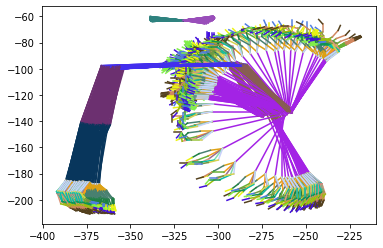

In [21]:
video.plot() # plota todos os frames em uma única imagem

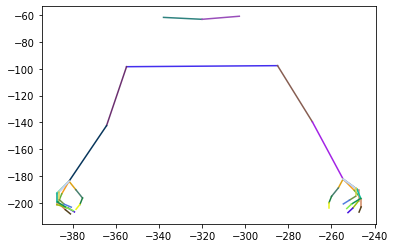

In [22]:
video.plot(frame=1) # plota o frame selecionado obs: Você pode mandar (1,10) que irá plotar do frame 1 ao 10

In [41]:
video.plot("/content") # salva o plot

<Figure size 432x288 with 0 Axes>

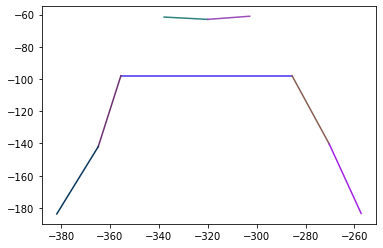

In [48]:
video.frames[0].body.plot() # plot apenas uma parte do corpo

In [76]:
video.plot_mp4('./') # salva vídeo dos keypoints

<Figure size 432x288 with 0 Axes>